<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes_SingleSource_fixedX/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [58]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 17 09:15:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    919MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [59]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [96]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = False
BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-6
EPOCHS = 1000
PATIENCE =13
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 2
OUTPUT_Y = 1
OUTPUT_D = 1

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 128
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 256

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 512
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :1]
        b = ab[:, 1:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)

        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_regression_fixed_x'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = os.path.join(DRIVE_PATH, 'Results', 'SingleSource_ByClasses_Fixed_X', 'traindata_Size_37250', 'checkpoint.pt')
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [0]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [0]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def weighted_MSE(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  label_a = label_a.to(device)
  label_b = label_b.to(device)
  label_y = label_y.to(device)
  label_d = label_d.to(device)

  weight = weight.to(device)
  
  a = a.view(len(a))
  b = b.view(len(b))
  y = y.view(len(y))
  d = d.view(len(d))

  crit1 = nn.MSELoss()
  crit2 = nn.MSELoss()
  crit3 = nn.MSELoss()
  crit4 = nn.MSELoss()

  return weight[0] * crit1(a, label_a) + weight[1] * crit2(b, label_b) + weight[2] * crit3(y, label_y) + weight[3] * crit4(d, label_d)

In [0]:

def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.0, 1.0, 1.1, 1.1])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, xy, d = net(x)
                    loss = weighted_MSE(a, b, xy, d, la, lb, ly, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, xy, d = net(x)
                    loss = weighted_MSE(a, b, xy, d, la, lb, ly, ld, weight)
                    val_losses.append(loss.item())

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                

                train_losses = []
                val_losses = []


                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [129]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<06:03,  2.75it/s]


loss :  1194.4697241210938 val loss :  1165.1645678710938 

Validation loss decreased (inf --> 1165.164568).  Saving model ...




  0%|          | 2/1000 [00:00<06:00,  2.77it/s]


loss :  1194.4160400390624 val loss :  1165.1015747070312 

Validation loss decreased (1165.164568 --> 1165.101575).  Saving model ...




  0%|          | 3/1000 [00:01<05:56,  2.80it/s]


loss :  1194.3124926757812 val loss :  1165.037451171875 

Validation loss decreased (1165.101575 --> 1165.037451).  Saving model ...




  0%|          | 4/1000 [00:01<05:57,  2.78it/s]


loss :  1194.2593505859375 val loss :  1164.9712133789062 

Validation loss decreased (1165.037451 --> 1164.971213).  Saving model ...




  0%|          | 5/1000 [00:01<05:53,  2.81it/s]


loss :  1194.1937719726564 val loss :  1164.8998828125 

Validation loss decreased (1164.971213 --> 1164.899883).  Saving model ...




  1%|          | 6/1000 [00:02<05:54,  2.81it/s]


loss :  1194.0823950195313 val loss :  1164.8205322265626 

Validation loss decreased (1164.899883 --> 1164.820532).  Saving model ...




  1%|          | 7/1000 [00:02<05:55,  2.79it/s]


loss :  1194.0193310546874 val loss :  1164.73068359375 

Validation loss decreased (1164.820532 --> 1164.730684).  Saving model ...




  1%|          | 8/1000 [00:02<06:01,  2.74it/s]


loss :  1193.8955224609374 val loss :  1164.624091796875 

Validation loss decreased (1164.730684 --> 1164.624092).  Saving model ...




  1%|          | 9/1000 [00:03<05:59,  2.75it/s]


loss :  1193.7267529296876 val loss :  1164.4858911132812 

Validation loss decreased (1164.624092 --> 1164.485891).  Saving model ...




  1%|          | 10/1000 [00:03<05:56,  2.78it/s]


loss :  1193.5598193359374 val loss :  1164.2869873046875 

Validation loss decreased (1164.485891 --> 1164.286987).  Saving model ...




  1%|          | 11/1000 [00:03<06:03,  2.72it/s]


loss :  1193.219931640625 val loss :  1163.9687768554688 

Validation loss decreased (1164.286987 --> 1163.968777).  Saving model ...




  1%|          | 12/1000 [00:04<05:59,  2.75it/s]


loss :  1192.709560546875 val loss :  1163.438994140625 

Validation loss decreased (1163.968777 --> 1163.438994).  Saving model ...




  1%|▏         | 13/1000 [00:04<05:54,  2.78it/s]


loss :  1191.704873046875 val loss :  1162.5055078125 

Validation loss decreased (1163.438994 --> 1162.505508).  Saving model ...




  1%|▏         | 14/1000 [00:05<05:51,  2.81it/s]


loss :  1190.4747387695313 val loss :  1161.0172119140625 

Validation loss decreased (1162.505508 --> 1161.017212).  Saving model ...




  2%|▏         | 15/1000 [00:05<05:49,  2.82it/s]


loss :  1188.4482983398439 val loss :  1158.9153002929688 

Validation loss decreased (1161.017212 --> 1158.915300).  Saving model ...




  2%|▏         | 16/1000 [00:05<05:55,  2.77it/s]


loss :  1186.2212915039063 val loss :  1156.2648095703125 

Validation loss decreased (1158.915300 --> 1156.264810).  Saving model ...




  2%|▏         | 17/1000 [00:06<05:54,  2.77it/s]


loss :  1182.085517578125 val loss :  1151.8526000976562 

Validation loss decreased (1156.264810 --> 1151.852600).  Saving model ...




  2%|▏         | 18/1000 [00:06<05:49,  2.81it/s]


loss :  1175.295498046875 val loss :  1143.9585961914063 

Validation loss decreased (1151.852600 --> 1143.958596).  Saving model ...




  2%|▏         | 19/1000 [00:06<05:46,  2.83it/s]


loss :  1163.5247631835937 val loss :  1130.0368701171874 

Validation loss decreased (1143.958596 --> 1130.036870).  Saving model ...




  2%|▏         | 20/1000 [00:07<05:45,  2.84it/s]


loss :  1141.5404052734375 val loss :  1105.6070532226563 

Validation loss decreased (1130.036870 --> 1105.607053).  Saving model ...




  2%|▏         | 21/1000 [00:07<05:45,  2.83it/s]


loss :  1103.0222973632813 val loss :  1063.2176098632813 

Validation loss decreased (1105.607053 --> 1063.217610).  Saving model ...




  2%|▏         | 22/1000 [00:07<05:43,  2.85it/s]


loss :  1041.06494140625 val loss :  993.31857421875 

Validation loss decreased (1063.217610 --> 993.318574).  Saving model ...




  2%|▏         | 23/1000 [00:08<05:46,  2.82it/s]


loss :  948.2819970703125 val loss :  888.1055517578125 

Validation loss decreased (993.318574 --> 888.105552).  Saving model ...




  2%|▏         | 24/1000 [00:08<05:51,  2.78it/s]


loss :  816.1975207519531 val loss :  752.3715759277344 

Validation loss decreased (888.105552 --> 752.371576).  Saving model ...




  2%|▎         | 25/1000 [00:08<05:48,  2.80it/s]


loss :  683.9195471191406 val loss :  624.8888671875 

Validation loss decreased (752.371576 --> 624.888867).  Saving model ...




  3%|▎         | 26/1000 [00:09<05:49,  2.79it/s]


loss :  617.2556188964844 val loss :  557.9100622558594 

Validation loss decreased (624.888867 --> 557.910062).  Saving model ...




  3%|▎         | 27/1000 [00:09<05:46,  2.81it/s]


loss :  586.9693603515625 val loss :  537.7936108398437 

Validation loss decreased (557.910062 --> 537.793611).  Saving model ...




  3%|▎         | 28/1000 [00:10<05:45,  2.82it/s]


loss :  587.8790600585937 val loss :  532.97138671875 

Validation loss decreased (537.793611 --> 532.971387).  Saving model ...




  3%|▎         | 29/1000 [00:10<05:40,  2.85it/s]


loss :  573.6670983886719 val loss :  533.8127337646484 

EarlyStopping counter: 1 out of 13




  3%|▎         | 30/1000 [00:10<05:44,  2.81it/s]


loss :  570.9320825195313 val loss :  531.7490954589844 

Validation loss decreased (532.971387 --> 531.749095).  Saving model ...




  3%|▎         | 31/1000 [00:11<05:43,  2.82it/s]


loss :  573.7904858398438 val loss :  526.4539697265625 

Validation loss decreased (531.749095 --> 526.453970).  Saving model ...




  3%|▎         | 32/1000 [00:11<05:44,  2.81it/s]


loss :  557.1065747070312 val loss :  524.9452966308594 

Validation loss decreased (526.453970 --> 524.945297).  Saving model ...




  3%|▎         | 33/1000 [00:11<05:42,  2.82it/s]


loss :  563.65736328125 val loss :  521.3836865234375 

Validation loss decreased (524.945297 --> 521.383687).  Saving model ...




  3%|▎         | 34/1000 [00:12<05:36,  2.87it/s]


loss :  554.3340612792969 val loss :  522.7077465820313 

EarlyStopping counter: 1 out of 13




  4%|▎         | 35/1000 [00:12<05:33,  2.89it/s]


loss :  552.9374719238281 val loss :  524.4075622558594 

EarlyStopping counter: 2 out of 13




  4%|▎         | 36/1000 [00:12<05:30,  2.92it/s]


loss :  555.5488256835938 val loss :  522.5240466308594 

EarlyStopping counter: 3 out of 13




  4%|▎         | 37/1000 [00:13<05:29,  2.92it/s]


loss :  565.7826928710938 val loss :  521.523804321289 

EarlyStopping counter: 4 out of 13




  4%|▍         | 38/1000 [00:13<05:31,  2.90it/s]


loss :  551.6069848632812 val loss :  518.5020812988281 

Validation loss decreased (521.383687 --> 518.502081).  Saving model ...




  4%|▍         | 39/1000 [00:13<05:29,  2.92it/s]


loss :  554.9170666503907 val loss :  518.8356677246094 

EarlyStopping counter: 1 out of 13




  4%|▍         | 40/1000 [00:14<05:34,  2.87it/s]


loss :  552.700029296875 val loss :  518.3352722167969 

Validation loss decreased (518.502081 --> 518.335272).  Saving model ...




  4%|▍         | 41/1000 [00:14<05:32,  2.89it/s]


loss :  547.58416015625 val loss :  518.3928100585938 

EarlyStopping counter: 1 out of 13




  4%|▍         | 42/1000 [00:14<05:28,  2.91it/s]


loss :  554.6683605957031 val loss :  518.8611584472657 

EarlyStopping counter: 2 out of 13




  4%|▍         | 43/1000 [00:15<05:32,  2.88it/s]


loss :  540.6627087402344 val loss :  515.6119006347657 

Validation loss decreased (518.335272 --> 515.611901).  Saving model ...




  4%|▍         | 44/1000 [00:15<05:29,  2.90it/s]


loss :  552.2952526855469 val loss :  516.7684594726562 

EarlyStopping counter: 1 out of 13




  4%|▍         | 45/1000 [00:15<05:32,  2.87it/s]


loss :  551.0705139160157 val loss :  515.0280883789062 

Validation loss decreased (515.611901 --> 515.028088).  Saving model ...




  5%|▍         | 46/1000 [00:16<05:35,  2.85it/s]


loss :  550.7955358886719 val loss :  515.8298266601563 

EarlyStopping counter: 1 out of 13




  5%|▍         | 47/1000 [00:16<05:34,  2.85it/s]


loss :  540.8465881347656 val loss :  515.0507604980469 

EarlyStopping counter: 2 out of 13




  5%|▍         | 48/1000 [00:16<05:33,  2.85it/s]


loss :  543.6744421386719 val loss :  512.2377136230468 

Validation loss decreased (515.028088 --> 512.237714).  Saving model ...




  5%|▍         | 49/1000 [00:17<05:29,  2.89it/s]


loss :  551.0777697753906 val loss :  513.3579406738281 

EarlyStopping counter: 1 out of 13




  5%|▌         | 50/1000 [00:17<05:32,  2.85it/s]


loss :  542.1395422363281 val loss :  512.0310009765625 

Validation loss decreased (512.237714 --> 512.031001).  Saving model ...




  5%|▌         | 51/1000 [00:18<05:30,  2.87it/s]


loss :  533.4632312011719 val loss :  510.71203247070315 

Validation loss decreased (512.031001 --> 510.712032).  Saving model ...




  5%|▌         | 52/1000 [00:18<05:26,  2.90it/s]


loss :  540.8903930664062 val loss :  511.4566455078125 

EarlyStopping counter: 1 out of 13


KeyboardInterrupt: ignored

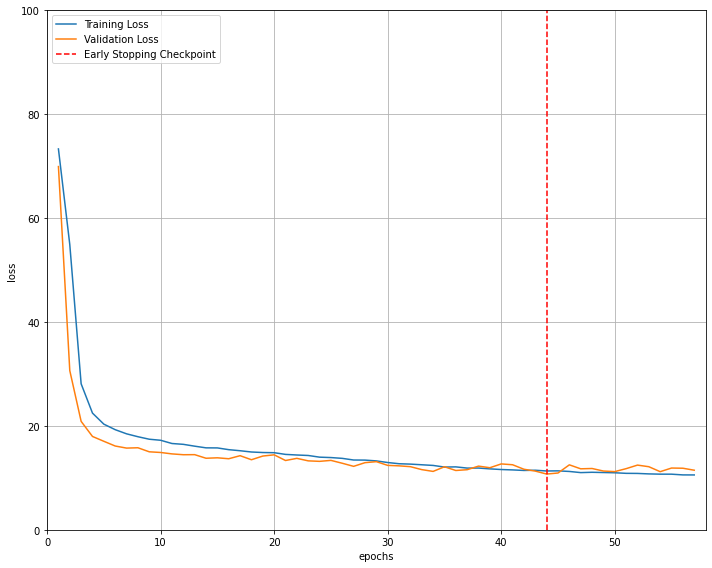

In [130]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, xy, d = net(x)

            #get class of a, b, d
            #_, aa = a.max(1)
            #_, bb = b.max(1)
            #_, dd = d.max(1)

            final_result = torch.cat([a, b, xy, d], dim = 1)
            #print(final_result.shape)
            #print(type(final_result))
            final_result = final_result.to("cpu")
            predictions.append(final_result)
            

    #print(predictions)
    #print()
    #predictions = np.array(predictions)
    #predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [0]:
#for f in tqdm(os.listdir(TEST_PATH_LABEL)):
#  path  = os.path.join(TEST_PATH_LABEL, f)
# testset = DataCaller_Excel(path, IMG_SIZE)
#  print(testset.__len__())
#  testsets.append(testset)

#testset = ConcatDataset(testsets)

In [0]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
trained_net = Net()
trained_net.load_state_dict(torch.load('checkpoint.pt'))
trained_net.to(device)
trained_net.eval()
test(trained_net)

In [176]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
#trained_net = Net()
load_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
load_net.to(device)
load_net.eval()
test(load_net)

NameError: ignored